In [2]:
# !python --version
# %pip install --upgrade pandas
# %pip install openpyxl
# %pip install numpy
# %pip install scikit-learn
# %pip install matplotlib
# %pip install plot_keras_history
# %pip install tensorflow
# %pip install keras-tuner
# %pip install -q keras-tcn --no-dependencies

In [3]:
import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

from tcn import TCN, tcn_full_summary

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization

print("TF version:", tf.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Insantes de tiempo futuros a predecir
numPredictions = 20

# Number of best models
numBestModels = 1

# Porcentaje del conjunto de test
test_size = 0.3
# Porcentaje del conjunto de validacion
val_size = 0.3

# Establecer objetivo (Name of model metric to minimize or maximize, e.g. "val_accuracy"). 
# El "val_" hace referencia a que se coge la métrica en el subconjunto de validación

# obje = kerastuner.Objective('val_mean_absolute_percentage_error', 'min')

# Epocas
epchs = 1000
# Tamaño del batch
batch = 1024
# Nodos internos
hidden_nodes = 10

# Units parameters
minUnits = 50
maxUnits = 200
stepsUnits = 50
defaultUnits = 50

# Layers parameters
minLayers = 1
maxLayers = 10
defaultLayers = 3

# Dropout Parameters
minDropout = 0
maxDropout = 0.33
defaultDropout = .25

# Establecer medida de loss
loss = "mean_absolute_error"

# Model metrics
modelMetrics = [keras.metrics.MAE, keras.metrics.RMSE]

# Learning rate
learningRate = [0.0, 1e-2, 1e-3, 1e-4]

# Optimizer objetive: error percetange with the validation set 
objective = kt.Objective('val_mean_absolute_error', 'min')

# Maximum model trials and executions
trials = 2
executions = 2

# Model saving parameters
workingDirectory = datetime.datetime.fromtimestamp(time.time()).strftime('%d-%m-%Y %hh:%mm')
projectName = "tcn"



TF version: 2.1.0
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


In [4]:
df = pd.read_excel("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/2015_30min.xlsx", 
                   header=None, 
                   engine='openpyxl')[0]

df2 = pd.read_excel("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/2016_30min.xlsx",
                    header = None, 
                    engine = 'openpyxl')[0]

In [5]:

# Data preprocessing: each row will contain the 20 measures for each day , and the 10 measures for the following day
X = pd.DataFrame(np.array(df).reshape(-1, 20))
Y = pd.DataFrame.copy(X)

Y.columns = ["col_{}".format(i) for i in range(21, 41)]
Y = Y.drop(0)
Y = Y.reset_index(drop=True)
Y.loc[len(Y)] = np.zeros(numPredictions)

# Last row is deleted because it is the one used for the real prediction, 
# it is not useful for the training of the model. 
X.drop(X.tail(1).index,inplace=True)
Y.drop(Y.tail(1).index,inplace=True)

print("X Preproccessed shape: ", X.shape)
print("Y Preproccessed shape: ", Y.shape)
print("---------------------------------------------")

#  Uncomment in order to normalize data
# Data Normalization
# scaler = MinMaxScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 21)])
# Y = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(21, 41)])

dfPreproccessed = pd.concat([X, Y], axis=1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xTest, yTrain, yTest = train_test_split(X, 
                                                Y, 
                                                test_size = test_size, 
                                                random_state = 0, 
                                                shuffle=False)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, 
                                            yTrain, 
                                            test_size = val_size, 
                                            random_state = 0,
                                            shuffle=False)

# Show subsets shapes
print("Shapes:")
print("xTrain:\t"+str(xTrain.shape))
print("yTrain:\t"+str(yTrain.shape))
print("xVal:\t"+str(xVal.shape))
print("yVal:\t"+str(yVal.shape))
print("xTest:\t"+str(xTest.shape))
print("yTest:\t"+str(yTest.shape))
print("---------------------------------------------")

X Preproccessed shape:  (364, 20)
Y Preproccessed shape:  (364, 20)
---------------------------------------------
DataFrame Preproccessed:
              0           1           2           3           4           5  \
0     96.691833  193.486833  700.986333  587.718333  454.512500  631.489833   
1    202.375667  166.977000  403.916667  340.241000  649.179667  708.682500   
2    109.810167  152.215167   84.124833  134.679500  183.520167  280.223333   
3    385.892667  406.789667  467.582500  380.776333  519.853833  493.757500   
4    278.043000  417.771833  342.662667  375.797833  460.997500  426.551500   
..          ...         ...         ...         ...         ...         ...   
359  366.420667  464.264667  552.852833  619.109000  665.427167  724.307333   
360  195.091333  258.723500  361.770833  478.921833  412.853000  273.145167   
361  290.458000  348.943000  487.557167  453.287500  454.995500  453.921167   
362  194.163333  413.427667  527.695167  358.897000  290.422333  344.84

In [6]:

# Model definition:
with tf.device('/gpu:0'): 
    
    def build_model(hp): 

        model = Sequential()
        
        # First layer: GRU. Number of units optimization
        model.add(TCN(units = hp.Int('units', 
                                    min_value = minUnits,
                                    max_value = maxUnits, 
                                    step = stepsUnits,
                                    default = defaultUnits),
                        return_sequences = False, 
                        input_shape = (xTrain.shape[1], 1),
                        kernel_size = 2, 
                        nb_filters = 256, 
                        dilations = [1, 2, 4, 8, 16, 32]))

        # Second layer: Dropout with percetange optimization
        model.add(
            Dropout(hp.Float('dropout', 
                            min_value = minDropout,
                            max_value = maxDropout,
                            default = defaultDropout)))
        
        # Last layer:
        model.add(Dense(numPredictions))

        print("Summary: ")
        model.summary()

        # # Set Epsilon to 1, in order to fix huge MAPE values.
        # keras.backend.set_epsilon(1)

        # Model compilation: learning rate optimization
        model.compile(loss = loss,
                    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                                values = learningRate)),
                    metrics = modelMetrics)

        return model
    


In [7]:
# Model training:
with tf.device('/gpu:0'): 
    # Create optimizer
    tcnOptimizer = RandomSearch(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectName,
                                overwrite = True)

    # Search space summary
    tcnOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    tcnOptimizer.search(x = xTrain,
                        y = yTrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data = (xVal.reshape((xVal.shape[0], xVal.shape[1], 1)), yVal))
    finalTime = time.time()

    # Results summary
    tcnOptimizer.results_summary()

    # Get best model generated
    model = tcnOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                xTrain.reshape((xTrain.shape[0], xTrain.shape[1], 1)),
                yTrain,
                epochs = epchs,
                batch_size = batch,
                validation_data = (xVal.reshape((xVal.shape[0], xVal.shape[1], 1)), yVal))

    # Show model info
    print("---------------------------------------------")
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    print("Tiempo de entrenamiento (en horas):\t"+str((finalTime - initialTime)/3600))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Traceback (most recent call last):
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-b109f0bbc73f>", line 18, in build_model
    dilations = [1, 2, 4, 8, 16, 32]))
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tcn\tcn.py", line 265, in __init__
    super(TCN, self).__init__(**kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 186, in __init__
    generic_utils.validate_kwargs(kwargs, allowed_kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\utils\generic_utils.py", line 718, in validate_kwargs
    raise TypeError(error_message, kwarg)
TypeError: ('Keyword

Traceback (most recent call last):
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-b109f0bbc73f>", line 18, in build_model
    dilations = [1, 2, 4, 8, 16, 32]))
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tcn\tcn.py", line 265, in __init__
    super(TCN, self).__init__(**kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 186, in __init__
    generic_utils.validate_kwargs(kwargs, allowed_kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\utils\generic_utils.py", line 718, in validate_kwargs
    raise TypeError(error_message, kwarg)
TypeError: ('Keyword

Traceback (most recent call last):
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-b109f0bbc73f>", line 18, in build_model
    dilations = [1, 2, 4, 8, 16, 32]))
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tcn\tcn.py", line 265, in __init__
    super(TCN, self).__init__(**kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 186, in __init__
    generic_utils.validate_kwargs(kwargs, allowed_kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\utils\generic_utils.py", line 718, in validate_kwargs
    raise TypeError(error_message, kwarg)
TypeError: ('Keyword

Traceback (most recent call last):
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-b109f0bbc73f>", line 18, in build_model
    dilations = [1, 2, 4, 8, 16, 32]))
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tcn\tcn.py", line 265, in __init__
    super(TCN, self).__init__(**kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 186, in __init__
    generic_utils.validate_kwargs(kwargs, allowed_kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\utils\generic_utils.py", line 718, in validate_kwargs
    raise TypeError(error_message, kwarg)
TypeError: ('Keyword

Traceback (most recent call last):
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-b109f0bbc73f>", line 18, in build_model
    dilations = [1, 2, 4, 8, 16, 32]))
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tcn\tcn.py", line 265, in __init__
    super(TCN, self).__init__(**kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 186, in __init__
    generic_utils.validate_kwargs(kwargs, allowed_kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\utils\generic_utils.py", line 718, in validate_kwargs
    raise TypeError(error_message, kwarg)
TypeError: ('Keyword

Traceback (most recent call last):
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-b109f0bbc73f>", line 18, in build_model
    dilations = [1, 2, 4, 8, 16, 32]))
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tcn\tcn.py", line 265, in __init__
    super(TCN, self).__init__(**kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 186, in __init__
    generic_utils.validate_kwargs(kwargs, allowed_kwargs)
  File "c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\keras\utils\generic_utils.py", line 718, in validate_kwargs
    raise TypeError(error_message, kwarg)
TypeError: ('Keyword

RuntimeError: Too many failed attempts to build model.

In [ ]:
with tf.device('/gpu:0'): 
# Model definition
    model = keras.models.Sequential()
    model.add(TCN(
        input_shape = (xTrain.shape[1], 1),
        kernel_size = 2, 
        nb_filters = 256, 
        dilations = [1, 2, 4, 8, 16, 32]))
    model.add(Dropout(rate = 0.25))
    model.add(Dense(numPredictions, activation ="sigmoid"))

    print("Model Summary: ", model.summary())

    # Set Epsilon to 1, in order to fix huge MAPE values.
    keras.backend.set_epsilon(1)

    # Model compilation
    model.compile(loss = loss,
                optimizer = "adam",
                metrics = [keras.metrics.MAE, 
                        keras.metrics.MAPE, 
                        keras.metrics.MSE])

    history = model.fit(
        np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1)),
        yTrain,
        epochs = epchs,
        batch_size = batch,
        validation_data = (np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1)), yVal))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 256)               1445888   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                5140      
Total params: 1,451,028
Trainable params: 1,451,028
Non-trainable params: 0
_________________________________________________________________
Model Summary:  None
Train on 177 samples, validate on 77 samples
Epoch 1/1000


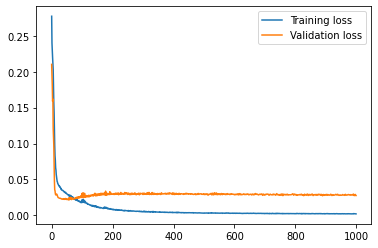

77/77 [==============================] - 0s 2ms/sample - loss: 0.0275 - mean_absolute_error: 0.1249 - mean_absolute_percentage_error: 59.5040 - mean_squared_error: 0.0275
Score: [0.02745496288135454, 0.12487876, 59.50399, 0.027454961]


In [ ]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1)), yVal)
print('Score:', score)